# Definitions 

In [1]:
from tensorsketch import * 

from autofaiss import build_index
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Experiment 

In [61]:
num_samples = 100000              #@param {type:"integer",min:100,step:100}
seq_len = 60                     #@param {type:"integer"}
alphabet_size = 4               
compute_edit_distance = False   #@param{type:"boolean"}
rates = np.linspace(.05,.3,6)      
samples, rates = gen_seqs(N=seq_len,
                          rates=rates,
                          A=alphabet_size,
                          num_samples=num_samples,
                         )

n, m, l = samples.shape
seqs = samples.reshape((-1,l))
pairs = np.array([(i*m,i*m+j+1) for i in range(n) for j in range(m-1)])

if compute_edit_distance:
    ed_dists = edit_dist_pairs(pairs,seqs,edit_dist)
    ed_dists = ed_dists.reshape((n,m-1))

generating seqs : 100%|██████████| 100000/100000 [00:09<00:00, 10788.62it/s]


In [62]:
tuple_size = 2              #@param {type:"slider",min:1,max:10,step:1}
sketch_dim = 100            #@param {type:"slider",min:10,max:1000,step:10} 

stride_ratio = 0.1          
window_ratio = 0.2     

stride = int(stride_ratio*seq_len)
window = int(window_ratio*seq_len)

common = dict(A=alphabet_size,D=sketch_dim,normalize=False)

models = {
    # 'MH': MH(k=kmer_size, **common),
    # 'TE': TE(t=tuple_size, A=alphabet_size),
    # 'TS': TS(t=tuple_size,  **common),
    'TSS': TSS(t=tuple_size, S=stride, seq_len=seq_len, W=window, **common),
}
all_sketches = {name:model.sketch(seqs) for name,model in models.items()}

In [63]:
sketches = all_sketches['TSS']
sketches = np.array(sketches).astype(np.float32)
# sketches = sketches/np.linalg.norm(sketches,axis=1)[:,np.newaxis]
len(sketches) / 1e6

0.7

In [64]:
index, index_infos = build_index(sketches,metric_type='l2', save_on_disk=False)

2022-07-28 03:33:45,131 [INFO]: Using 24 omp threads (processes), consider increasing --nb_cores if you have more
2022-07-28 03:33:45,286 [INFO]: Launching the whole pipeline 07/28/2022, 03:33:45
2022-07-28 03:33:45,286 [INFO]: Reading total number of vectors and dimension 07/28/2022, 03:33:45
100%|██████████| 1/1 [00:00<00:00, 9000.65it/s]
2022-07-28 03:33:45,306 [INFO]: There are 700000 embeddings of dim 117
2022-07-28 03:33:45,306 [INFO]: >>> Finished "Reading total number of vectors and dimension" in 0.0196 secs
2022-07-28 03:33:45,307 [INFO]: 	Compute estimated construction time of the index 07/28/2022, 03:33:45
2022-07-28 03:33:45,308 [INFO]: 		-> Train: 16.7 minutes
2022-07-28 03:33:45,308 [INFO]: 		-> Add: 0.9 seconds
2022-07-28 03:33:45,309 [INFO]: 		Total: 16.7 minutes
2022-07-28 03:33:45,310 [INFO]: 	>>> Finished "Compute estimated construction time of the index" in 0.0017 secs
2022-07-28 03:33:45,311 [INFO]: 	Checking that your have enough memory available to create the ind

In [65]:
%%time
D,I = index.search(sketches[::(len(rates)+1)].astype(np.float32),2000)

CPU times: user 39min 35s, sys: 25.9 s, total: 40min
Wall time: 1min 45s


In [66]:
starts = np.arange(0,len(sketches),len(rates)+1)
diffs = I - starts[:,np.newaxis]
FP = (diffs<0)|(diffs>len(rates))
TP = ~FP 
FP = np.cumsum(FP,1)
ds = np.unique(diffs[TP])
df = pd.DataFrame(columns=['mutation','recall','precision'])
for d,mr in tqdm.tqdm(zip(ds,rates),total=len(ds)):
    for q in np.linspace(.1,1,10):
        fp = np.quantile(FP[diffs==d],q=q)
        recall = np.sum(diffs==d)*q / len(diffs)
        p = 1/(1+fp)
        df.loc[len(df),:] = (mr,recall,p)

 86%|████████▌ | 6/7 [00:25<00:04,  4.28s/it]


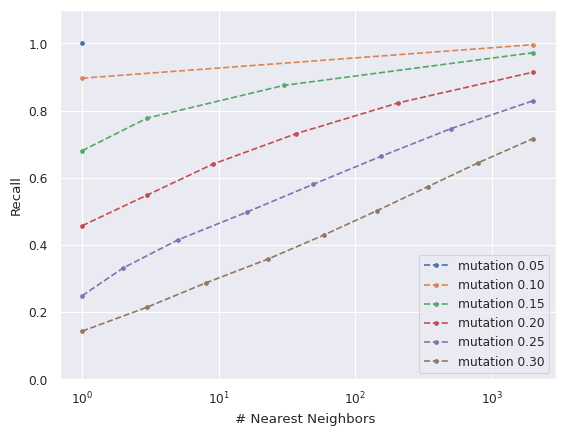

In [67]:
mrs = df['mutation'].unique().tolist()
for mr in mrs:
    sdf = df.loc[df.mutation==mr]
    sdf = sdf[~sdf['precision'].duplicated(keep='last')]
    plt.plot(1/sdf['precision'],sdf['recall'],'--.',)
plt.legend([f'mutation {mr:.2f}' for mr in mrs],loc='lower right')
plt.xlabel(f'# Nearest Neighbors ')
plt.ylabel('Recall')
plt.xscale('log')
# plt.yscale('log')
plt.ylim(0,1.1)
plt.savefig(f'seqlen{seq_len}')
plt.show()


In [60]:
diffs[0][:20]

array([     0,      3, 165394, 256823,      1, 185558, 683001, 292692,
       638968, 267405, 335447, 357575,  79014, 694582, 288730, 208915,
       476667,      2, 292691, 488376])